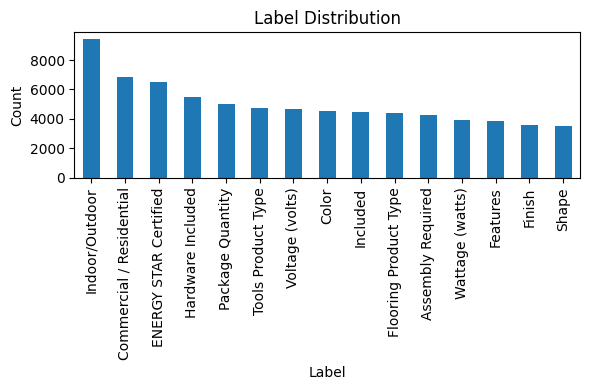

| word         |   frequency |
|:-------------|------------:|
| use          |       42126 |
| light        |       36073 |
| easy         |       35089 |
| installation |       32938 |
| design       |       31087 |
| finish       |       29593 |
| home         |       28618 |
| door         |       23740 |
| features     |       21844 |
| wall         |       21457 |
| water        |       21084 |
| steel        |       20088 |
| provides     |       19616 |
| glass        |       19033 |
| wood         |       18454 |
| tile         |       18141 |
| watt         |       17982 |
| used         |       17576 |
| energy       |       16839 |
| protection   |       16159 |
Classification Report:
                          precision    recall  f1-score   support

       Assembly Required       0.58      0.66      0.61       853
                   Color       0.44      0.41      0.42       901
Commercial / Residential       0.33      0.30      0.31      1373
   ENERGY STAR Certified      

<Figure size 500x500 with 0 Axes>

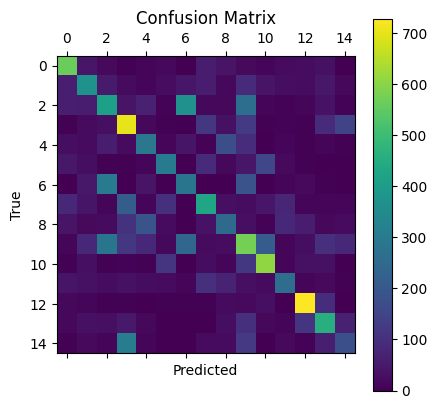

Sample Misclassified Examples:
> True: Tools Product Type, Pred: Voltage (volts)
  → ridgid introduces new volt amp hour hyper lithiumion battery battery user runtime longer life compared standard lithiumion batteries best battery compatible ridgid volt tools lithiumion chargerscalifornia residents seenbspproposition informationfuel gaugealways know power level jobcold weather performance battery operates ftriple protection electronicsprotects battery overcharge overheating overloadingeco options energy star certifiedyear limited warranty

> True: Color, Pred: Assembly Required
  → triview medicine cabinet ideal upgrade bathroom perfect complement strasser simplicity series bath vanities homeowners seeking stylish medicine cabinet vanity complete set overall perfect optimize storage aesthetically balanced interior mirrored brightens inside highlights contents make easy interior acrylic shelves adjustable convenience popular satin nickel knobs included accent set crown molding adds clas

In [ ]:
# 1. Imports & Data Loading
import pandas as pd
import re

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the training texts and their labels
train_data   = pd.read_csv('/content/train_data.csv')
train_labels = pd.read_csv('/content/train_label.csv')
train = train_data.merge(train_labels, on='id')

# 2. Noise Removal / Text Preprocessing
def preprocess_text(text):
    text = text.lower()                             # lowercase
    text = re.sub(r'<.*?>', '', text)               # strip HTML tags
    text = re.sub(r'[^a-z\s]', '', text)            # remove punctuation & digits
    tokens = [
        w for w in text.split()
        if w not in ENGLISH_STOP_WORDS and len(w) > 2
    ]
    return ' '.join(tokens)

train['clean_text'] = train['text'].apply(preprocess_text)

# 3. Exploratory Data Visualization

# 3a. Label Distribution
plt.figure(figsize=(6,4))
train['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3b. Top‐20 Most Frequent Words
cv = CountVectorizer(max_features=20)
X_counts = cv.fit_transform(train['clean_text'])
freq = X_counts.toarray().sum(axis=0)
freq_df = pd.DataFrame({
    'word':      cv.get_feature_names_out(),
    'frequency': freq
}).sort_values('frequency', ascending=False)
print(freq_df.to_markdown(index=False))


# 4. Train/Validation Split
X = train['clean_text']
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 5. Baseline Model Fitting
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf',   LogisticRegression(solver='saga', max_iter=1000))
])
pipeline.fit(X_train, y_train)

# 6. Performance on Validation Set
y_pred = pipeline.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,5))
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()


# 7. Analyzing Mistakes
val_df = pd.DataFrame({
    'text': X_val,
    'true_label': y_val,
    'pred_label': y_pred
})
mis_df = val_df[val_df['true_label'] != val_df['pred_label']].sample(10, random_state=42)
print("Sample Misclassified Examples:")
for i, row in mis_df.iterrows():
    print(f"> True: {row.true_label}, Pred: {row.pred_label}\n  → {row.text}\n")


# 8. Improving the Model via GridSearch
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_val)
print("Best parameters:", grid.best_params_)
print("Improved Classification Report:")
print(classification_report(y_val, y_pred_best))

In [ ]:
# 1. Get your tuned model
best_model = grid.best_estimator_

# 2. Load & clean test set
test = pd.read_csv('/content/test_data.csv')   # columns: id, text
test['clean_text'] = test['text'].apply(preprocess_text)

# 3. Generate probability matrix
probs = best_model.predict_proba(test['clean_text'])
classes = best_model.classes_        # array of label names in the correct order

# 4. Build submission DataFrame
submission = pd.DataFrame(probs, columns=classes)
submission.insert(0, 'id', test['id'])  # ensure 'id' is first column

# 5. Save to CSV
submission.to_csv('sample_submission.csv', index=False)

print(submission.head())


       id  Assembly Required     Color  Commercial / Residential  \
0  114689           0.000106  0.000358                  0.000587   
1  183172           0.000393  0.002265                  0.000728   
2  217304           0.004980  0.026774                  0.001571   
3  184115           0.000799  0.009337                  0.207213   
4  103786           0.023467  0.313196                  0.205794   

   ENERGY STAR Certified  Features    Finish  Flooring Product Type  \
0               0.000363  0.000182  0.263185               0.000333   
1               0.001489  0.000429  0.000181               0.000214   
2               0.002459  0.001926  0.006061               0.000647   
3               0.005368  0.003544  0.003439               0.380102   
4               0.018534  0.021417  0.020139               0.013247   

   Hardware Included  Included  Indoor/Outdoor  Package Quantity     Shape  \
0           0.000499  0.000414        0.163667          0.566003  0.000097   
1       